# Click-through Rate Prediction 

This project is an analysis for the [kaggle competition](https://www.kaggle.com/c/avazu-ctr-prediction) for Avazu. Using 11 days worth of Avazu data (mobile ads), I am going to build and test prediction models for the ad click-through rate using a simple Random Forest Model. The challenge for this competition lies in the magnificent size of the data, where training set includes 3.2M rows (~6.7GB). Some of the approaches were attempted to improve memory efficiency, including (1) converting data types to `int16` or `int8` for integers (instead of using `int64`) and use `category` for strings instead of objects; (2) using feather format for saving and loading dataframes.

The project also explores the importance of feature engineering, by combining different methods such as concatenating variables, adding count features per group and target mean encoding.   

In [ ]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

In [3]:
import numpy as np
import pandas as pd
import pickle
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, forest
from sklearn.metrics import log_loss, f1_score, auc, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
path = "avazu/"

In [5]:
def save_feather(test_df=False):
    train_set.to_feather(path+"train_set")
    val_set.to_feather(path+"val_set")
    if test_df: test_set.to_feather(path+"test_set")
    
def load_feather(test_df=False):
    train = pd.read_feather(path+"train_set")
    val = pd.read_feather(path+"val_set")
    if test_df: 
        test = pd.read_feather(path+"test_set")
        return train, val, test
    else: 
        return train, val

In [6]:
def df_dtype(df):
    dict_type = {}
    for col, typ in df.dtypes.items():
        if str(typ) not in dict_type: dict_type[str(typ)] = [col]
        else: dict_type[str(typ)].append(col)
    return dict_type

def convert_numtype(df):
    dtype = df_dtype(df)
    try: 
        for col in dtype['float64']: df[col] = df[col].astype(np.float32)
    except: print("No float64 columns")
    try: 
        for col in dtype['int64']: 
            if col!= 'index': df[col] = df[col].astype(np.int32)
    except: print("No int64 columns")
    # return df_dtype(df)
    
def convert_cat(df, cols, typ):
    for col in cols: df[col]= df[col].astype(typ)

In [7]:
# YOUR CODE HERE
train_dtype = {'id': np.uint32, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint8,
         'site_id': object, 'site_domain': object, 'site_category': object, 'app_id': object,
         'app_domain': object, 'app_category': object, 'device_id': object,
         'device_ip': object, 'device_model': object, 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

test_dtype = {'id': np.uint32, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint8,
         'site_id': object, 'site_domain': object, 'site_category': object, 'app_id': object,
         'app_domain': object, 'app_category': object, 'device_id': object,
         'device_ip': object, 'device_model': object, 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
# raise NotImplementedError()

In [8]:
%%time
data = pd.read_csv(path + "train",
                   usecols=train_dtype.keys(), dtype=train_dtype, low_memory=False)
print(data.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  uint32
click               uint8
hour                uint32
C1                  uint32
banner_pos          uint8
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         uint8
device_conn_type    uint8
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: object(9), uint16(8), uint32(3), uint8(4)
memory usage: 23.2 GB
None
CPU times: user 3min 5s, sys: 16.8 s, total: 3min 22s
Wall time: 3min 22s


In [9]:
test_set = pd.read_csv(path + "test", dtype=test_dtype)

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,40428967.0,2.147588e+09,1.239805e+09,217.0,1.074381e+09,2.147369e+09,3.221347e+09,4.294967e+09
click,40428967.0,1.698056e-01,3.754620e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
hour,40428967.0,1.410256e+07,2.966837e+02,14102100.0,1.410230e+07,1.410260e+07,1.410281e+07,1.410302e+07
C1,40428967.0,1.004968e+03,1.094586e+00,1001.0,1.005000e+03,1.005000e+03,1.005000e+03,1.012000e+03
banner_pos,40428967.0,2.880146e-01,5.063820e-01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00
device_type,40428967.0,1.015305e+00,5.274336e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
device_conn_type,40428967.0,3.313150e-01,8.547935e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
C14,40428967.0,1.884181e+04,4.959457e+03,375.0,1.692000e+04,2.034600e+04,2.189400e+04,2.405200e+04
C15,40428967.0,3.188831e+02,2.127250e+01,120.0,3.200000e+02,3.200000e+02,3.200000e+02,1.024000e+03
C16,40428967.0,6.010201e+01,4.729538e+01,20.0,5.000000e+01,5.000000e+01,5.000000e+01,1.024000e+03


### Add new features for date, time and day of week based on column `hour`

First, I would like to extract the day, day of week and hour information from the column `hour`. Also, in order to have a continuous time series, the column `week_hour` that starts from zero and will accumulate hours till the last day of the training / testing data.

In [10]:
def proc_date(df, date_fld):
    df['date'] = pd.to_datetime(df[date_fld], format="%y%m%d%H")
    for n in ('hour', 'day', 'dayofweek'):
        df["click_"+n] = getattr(df['date'].dt, n)
    df.drop(['date'], axis=1, inplace=True)
    df['hour_prev'] =  df['click_hour']-1
    df['hour_next'] =  df['click_hour']+1
    df['wk_hour'] =  df['click_dayofweek']*24 + df['click_hour']
    df['wk_hour_prev'] =  df['wk_hour']-1
    df['wk_hour_next'] =  df['wk_hour']+1
    
    for col in ['click_hour', 'click_day', 'click_dayofweek',
                'wk_hour', 'wk_hour_prev', 'wk_hour_next']:
        df[col] = df[col].astype('int8')

In [11]:
proc_date(data, 'hour')
proc_date(test_set, 'hour')

In [12]:
# convert type for memory
for col in ['hour_prev', 'hour_next']:
    data[col] = data[col].astype('int8')
    test_set[col] = data[col].astype('int8')

In [13]:
data.tail().transpose().tail(10)

,40428962,40428963,40428964,40428965,40428966
C21,23,221,46,23,221
click_hour,23,23,23,23,23
click_day,30,30,30,30,30
click_dayofweek,3,3,3,3,3
hour_prev,22,22,22,22,22
hour_next,24,24,24,24,24
wk_hour,95,95,95,95,95
wk_hour_prev,94,94,94,94,94
wk_hour_next,96,96,96,96,96
user_id,a99f214adcf40646d9a2d3a9,a99f214ae5751bb2cd5b1559,a99f214a47e5bb5b2cd8ff6d,454877d92dfaa2fbf063b808,a99f214a372c853c711ee120


Looking at how the probability of click per hour varies significantly between each hour, so we should create features that could highlight what contributes to this variation. The featuresthat are to be engineered include:  
- Count per users in every hour, in the previous hour and the next hour
- Probability of click per hour

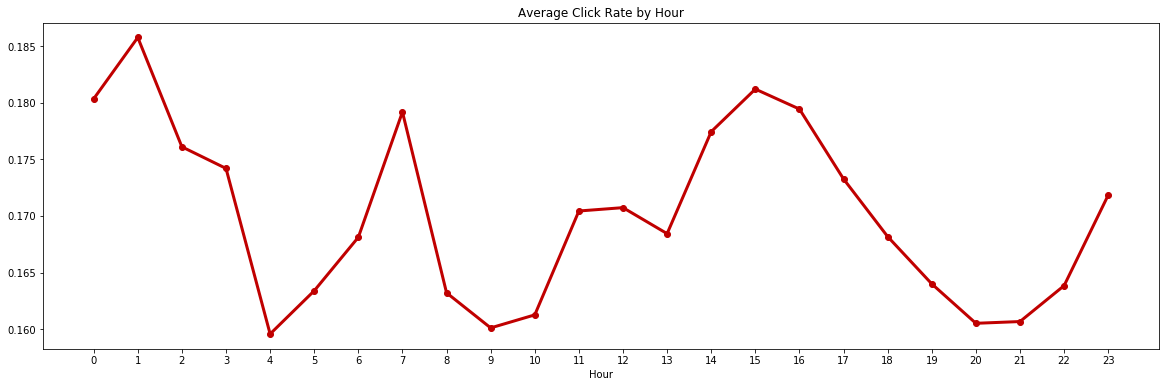

In [14]:
plt.figure(figsize=(20,6))
fld = "click_hour"
tmp = data.groupby(fld).click.mean().reset_index()
plt.plot(tmp[fld], tmp["click"], linewidth=3.0, marker='o', color="#C00000")
plt.title("Average Click Rate by Hour")
plt.xticks(np.arange(0, 24, 1))
plt.xlabel("Hour")
plt.show()

Notice how there is quite an imbalance in data distribution, the majority of ads (83%) were not clicked. We will need to take this to take into account while buidling the random forest model. 

In [15]:
# imbalanced dataset
data.click.value_counts()/len(data)

0    0.830194
1    0.169806
Name: click, dtype: float64

We also would like to observe the counts of click and no click on a specific day of the week. Herein, Tuesday-Thursday seem to have the highest number of samples in the training dataset. The testing set is only on Friday (label `4`), so it will be helpful if we include the probability of click per day of week as an additional feature 

In [16]:
test_set['click_dayofweek'].unique()

array([4])

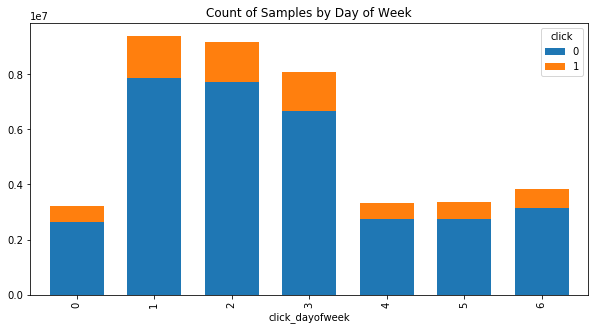

In [17]:
# number of clicks & no clicks by day of week
tmp = data.groupby(['click_dayofweek', 'click']).agg({'id': 'count'})
tmp = tmp.pivot_table(columns=['click'], index=['click_dayofweek'], values='id')
tmp.loc[:,[0,1]].plot.bar(stacked=True, width=0.7, figsize=(10,5))
plt.title("Count of Samples by Day of Week")

Amongst the anomynized columns C1, C14-C17, we also observe some imbalanced distribution for variable `C21`, it will also be helpful to include the probability of click / average number of clicks by label for this categorical variable:

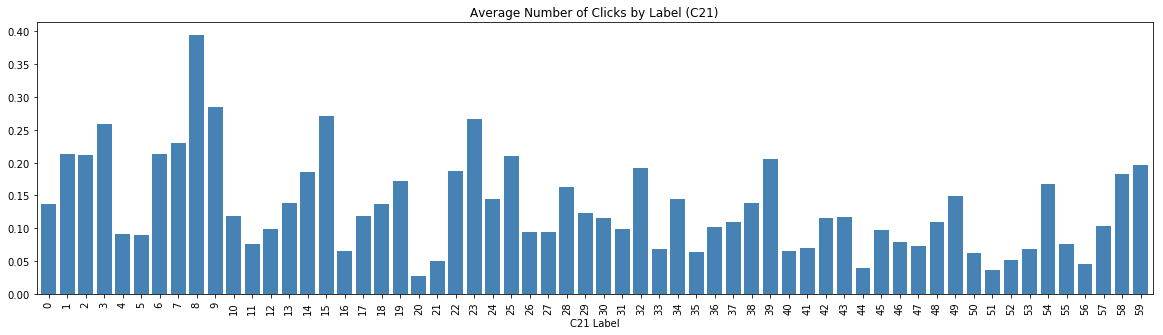

In [18]:
# column by anomynized columns
tmp = data.groupby('C21').click.mean().reset_index()
tmp['click'].plot.bar(color= 'steelblue', width=0.8, figsize=(20,5))
plt.title("Average Number of Clicks by Label (C21)")
plt.xlabel("C21 Label")

User in this case study will be identified by `user_id` as a combination of `device_id`, `device_ip` and `device_model`:

In [21]:
# create user_id using device_id, device_ip, device_model
for df in [data, test_set]:
    df['user_id'] = df['device_id']+df['device_ip']+df['device_model']

In [23]:
data.to_feather(path+"data_ft")
test_set.to_feather(path+"test_set")

### Split Train & Validation

Instead of using the split ratio of 80:20, since this data is a time series and we would like to have a validation set as close as possible to the test set, observations of day 29 and 30 will be the validation set and anything else will remain as training data.

In [7]:
%%time
data = pd.read_feather(path + "data_ft")
test_set = pd.read_feather(path + "test_set")

CPU times: user 23.6 s, sys: 13.1 s, total: 36.6 s
Wall time: 36.6 s


In [8]:
def split_based_hour(data, col):
    """ Split data based on column hour. Modified to take other columns
    """
    # N = int(0.8*len(data))
    # data = data.sort_values(by=col)-data was ordered chronologically
    train = data[data['click_day']<29]
    val = data[data['click_day']>=29]
    return train.reset_index(), val.reset_index()

In [9]:
# split train and validation
train_set, val_set = split_based_hour(data, col='dt')
print(train_set.shape, val_set.shape)

(32377421, 34) (8051546, 34)


In [10]:
save_feather(test_df=True)

#### Target Mean Encoding

Using the mean encoding method, we will calculate the probability of click by hour, day of week, device_id, connection type, banner position, etc. The column C14-C21 are also categorical variables but most of them have high cardinality, so only column C21 is appropriate to be target encoded.

In [6]:
train_set, val_set, test_set = load_feather(test_df=True)

In [12]:
for col in ["click_hour", "click_dayofweek", "wk_hour",
             "device_type", "device_conn_type","banner_pos",
             "site_category", "app_category", "device_type", "C21"]:
    print("processing %s" % col)
    gby = train_set.groupby(col).click.mean()
    train_set['click_gby_'+col] = train_set[col].map(gby)
    val_set['click_gby_'+col] = val_set[col].map(gby)
    test_set['click_gby_'+col] = test_set[col].map(gby)
    
    # fill na
    click_global_mean = train_set.click.mean()
    val_set['click_gby_'+col].fillna(click_global_mean, inplace=True)
    test_set['click_gby_'+col].fillna(click_global_mean, inplace=True)

processing click_hour
processing click_dayofweek
processing wk_hour
processing device_type
processing device_conn_type
processing banner_pos
processing site_category
processing app_category
processing device_type
processing C21


In [13]:
train_set.head()

,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,user_id,click_gby_click_hour,click_gby_click_dayofweek,click_gby_wk_hour,click_gby_device_type,click_gby_device_conn_type,click_gby_banner_pos,click_gby_site_category,click_gby_app_category,click_gby_C21
0,0,2096162817,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,a99f214addd2926e44956a24,0.182544,0.161828,0.179724,0.17095,0.141877,0.166862,0.211465,0.200849,0.190324
1,1,871065379,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,a99f214a96809ac8711ee120,0.182544,0.161828,0.179724,0.17095,0.182639,0.166862,0.211465,0.200849,0.190324
2,2,1015674494,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,a99f214ab3cf8def8a4875bd,0.182544,0.161828,0.179724,0.17095,0.182639,0.166862,0.211465,0.200849,0.190324
3,3,3573304040,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,a99f214ae8275b8f6332421a,0.182544,0.161828,0.179724,0.17095,0.182639,0.166862,0.211465,0.200849,0.190324
4,4,2926390960,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,...,a99f214a9644d0bf779d90c2,0.182544,0.161828,0.179724,0.17095,0.182639,0.182691,0.052671,0.200849,0.115366


In [14]:
# combine anomynized columns
for df in [train_set, val_set, test_set]: 
    df['c_combined'] = df['C1']+df['C14']+df['C15']+df['C16']+df['C17']+df['C18']+df['C19']+\
                        df['C20']+df['C21']

In [15]:
save_feather(test_df=True)

#### Count Features

The next type of feature is count the number of samples for each label of `device_ip`, `device_id`, `user_id` in the dataset. The number of times a user appears for every hour will also be added as a feature.

_Rerefence: https://www.csie.ntu.edu.tw/~r01922136/slides/kaggle-avazu.pdf_

In [7]:
train_set, val_set, test_set = load_feather(test_df=True)

In [16]:
for col in ['device_ip', 'device_id', 'user_id']: 
    count = train_set.groupby(col).index.count()
    train_set['cnt_'+col] = train_set[col].map(count)
    val_set['cnt_'+col] = val_set[col].map(count)
    test_set['cnt_'+col] = test_set[col].map(count)

In [17]:
cols = ['user_id', 'click_hour']
hour_user_cnt = train_set.groupby(cols).agg({'index': 'count'}).reset_index()
hour_user_cnt.columns = [ cols[0], cols[1], 'cnt_by_user_hour' ]

train_set = pd.merge(train_set, hour_user_cnt, how='left', on=cols)
val_set = pd.merge(val_set, hour_user_cnt, how='left', on=cols)
test_set = pd.merge(test_set, hour_user_cnt, how='left', on=cols)

In [18]:
for col in ['cnt_device_ip', 'cnt_device_id', 'cnt_user_id', 'cnt_by_user_hour']:
    val_set[col].fillna(0, inplace=True)
    test_set[col].fillna(0, inplace=True)

In [19]:
train_set.head()

,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,click_gby_device_conn_type,click_gby_banner_pos,click_gby_site_category,click_gby_app_category,click_gby_C21,c_combined,cnt_device_ip,cnt_device_id,cnt_user_id,cnt_by_user_hour
0,0,2096162817,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.141877,0.166862,0.211465,0.200849,0.190324,84452,58181,26752430,82,4
1,1,871065379,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.182639,0.166862,0.211465,0.200849,0.190324,53463,7,26752430,7,3
2,2,1015674494,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.182639,0.166862,0.211465,0.200849,0.190324,53463,4,26752430,4,2
3,3,3573304040,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.182639,0.166862,0.211465,0.200849,0.190324,53465,39,26752430,3,3
4,4,2926390960,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,...,0.182639,0.182691,0.052671,0.200849,0.115366,88256,31,26752430,31,15


### Interactive Features Pair

Concatenating possibly related features, such as `app_id`-`device_model`, `site-id`-`device_model` which can capture the impact of each app / site on different device models also sounds like a beneficial addition to the classification. Some companies have a very different market share between mobile and desktop, and so will their marketing impact on different channels. 

_Rerefence: https://www.csie.ntu.edu.tw/~r01922136/slides/kaggle-avazu.pdf_

In [9]:
def create_interac(col1, col2, train, val, test):
    # add concatenated columns    
    new_col = "_".join([col1, col2])
    train[new_col] = (train[col1]+train[col2]).astype('category')
    val[new_col] = (val[col1]+val[col2]).astype('category')
    test[new_col] = (test[col1]+test[col2]).astype('category')

In [10]:
for cols in [['app_id', 'site_id'], 
             ['app_domain', 'site_domain'],
             ['app_id', 'device_model'],
             ['site_id', 'device_model'],
             ['site_id', 'site_domain']]:
    create_interac(cols[0], cols[1], train_set, val_set, test_set)

In [11]:
save_feather(test_df=True)

### User Click History

In addition to the number of times a user appears per hour, we also care about the number of times he/she appear in the hour before and next, so we have a little time-series of hourly user count within an interval of 3 hours.

In [12]:
cols = ['user_id', 'click_hour']
hour_user_cnt = train_set.groupby(cols).agg({'index': 'count'}).reset_index()
hour_user_cnt.columns = [ cols[0], cols[1], 'cnt_by_user_hour' ]

In [14]:
# user visit counts next hour
hour_user_cnt.columns = [ 'user_id', 'hour_next','cnt_by_user_hour_next']
cols = ['user_id', 'hour_next']

train_set = pd.merge(train_set, hour_user_cnt, how='left', on=cols)
val_set = pd.merge(val_set, hour_user_cnt, how='left', on=cols)
test_set = pd.merge(test_set, hour_user_cnt, how='left', on=cols)

In [15]:
train_set.head()

,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,click_gby_site_category,click_gby_app_category,click_gby_C21,c_combined,app_id_site_id,app_domain_site_domain,app_id_device_model,site_id_device_model,site_id_site_domain,cnt_by_user_hour_next
0,0,2096162817,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.211465,0.200849,0.190324,84452,ecad23861fbe01fe,7801e8d9f3845767,ecad238644956a24,1fbe01fe44956a24,1fbe01fef3845767,4.0
1,1,871065379,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.211465,0.200849,0.190324,53463,ecad23861fbe01fe,7801e8d9f3845767,ecad2386711ee120,1fbe01fe711ee120,1fbe01fef3845767,NaN
2,2,1015674494,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.211465,0.200849,0.190324,53463,ecad23861fbe01fe,7801e8d9f3845767,ecad23868a4875bd,1fbe01fe8a4875bd,1fbe01fef3845767,NaN
3,3,3573304040,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,0.211465,0.200849,0.190324,53465,ecad23861fbe01fe,7801e8d9f3845767,ecad23866332421a,1fbe01fe6332421a,1fbe01fef3845767,NaN
4,4,2926390960,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,...,0.052671,0.200849,0.115366,88256,ecad2386fe8cc448,7801e8d99166c161,ecad2386779d90c2,fe8cc448779d90c2,fe8cc4489166c161,16.0


In [16]:
# user visit counts previous hour
hour_user_cnt.columns = [ 'user_id', 'hour_prev','cnt_by_user_hour_prev']
cols = ['user_id', 'hour_prev']

train_set = pd.merge(train_set, hour_user_cnt, how='left', on=cols)
val_set = pd.merge(val_set, hour_user_cnt, how='left', on=cols)
test_set = pd.merge(test_set, hour_user_cnt, how='left', on=cols)

In [17]:
# fill missing values with zero for the count
for col in ['cnt_by_user_hour_next', 'cnt_by_user_hour_prev']:
    train_set[col].fillna(0, inplace=True)
    val_set[col].fillna(0, inplace=True)
    test_set[col].fillna(0, inplace=True)

In [25]:
c_cols = ["C1"] + ["C"+str(i) for i in range(14,22)]
cat_cols = ['banner_pos', 'device_type', 'device_conn_type']+ c_cols + \
           ['site_id','site_domain','site_category',
            'app_id','app_domain','app_category',
            'device_id','device_ip','device_model','user_id']

for df in [train_set, val_set, test_set]: 
    convert_cat(df, cat_cols, 'category')

In [27]:
try: 
    train_set = train_set.drop(['hour'], axis=1)
    val_set = val_set.drop(['hour'], axis=1)
except: print("No index column")

In [31]:
save_feather(test_df=True)

### Final Pre-processing

The final step of pre-processing data is to convert the dataset into two dataframes of predictors and target variable, in this case will be variable `click`.

In [7]:
train_set, val_set, test_set = load_feather(test_df=True)

In [8]:
features = [c for c in train_set.columns if c != 'click']
X_train, y_train = train_set[features], train_set['click'].values
X_val, y_val = val_set[features], val_set['click'].values
X_test = test_set

### Label Encoding

After creating all necessary features, we are going to use label encoding to encode the categorical variables. Because we are using random forest, label encoding is one of the appropriate methods.

In [12]:
encode_cols = ['app_id_site_id', 'app_domain_site_domain', 'app_id_device_model',
               'site_id_device_model', 'site_id_site_domain',
               'site_category', 'app_category','user_id'] + \
             ['site_id', 'site_domain', 'app_id', 'app_domain',
             'device_id', 'device_ip', 'device_model']

In [13]:
for col in encode_cols: 
    print("processing ", col)
    le = LabelEncoder()
    all_label = np.hstack([X_train[col].values, X_val[col].values, X_test[col].values])
    all_label = np.unique(all_label)
    le.fit(list(all_label))
    X_train[col] = le.transform(X_train[col])
    X_val[col] = le.transform(X_val[col])
    X_test[col] = le.transform(X_test[col])

processing  app_id_site_id
processing  app_domain_site_domain
processing  app_id_device_model
processing  site_id_device_model
processing  site_id_site_domain
processing  site_category
processing  app_category
processing  user_id
processing  site_id
processing  site_domain
processing  app_id
processing  app_domain
processing  device_id
processing  device_ip
processing  device_model


In [14]:
for df in [X_train, X_val, X_test]: 
    convert_cat(df, encode_cols, 'category')
    convert_numtype(df)

No float64 columns
No int64 columns
No float64 columns
No int64 columns
No float64 columns
No int64 columns


### Random Forest Model

In [9]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((32377421, 47), (32377421,), (8051546, 47), (8051546,))

In [10]:
from sklearn.externals import joblib
from sklearn.externals.joblib import parallel_backend

In [11]:
# Source code: fast.ai
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [12]:
reset_rf_samples()
set_rf_samples(5000000)

In [13]:
rf = RandomForestClassifier(n_estimators=25,
                            min_samples_leaf=10,
                            min_samples_split=100,
                            max_features='sqrt',
                            random_state=42,
                            criterion='entropy',
                            n_jobs=-1, bootstrap=False)

In [14]:
%%time
with parallel_backend('threading'):
     rf.fit(X_train, y_train)

In [15]:
joblib.dump(rf, 'rf25_3.pkl') 

In [16]:
y_pred_proba_trn = rf.predict_proba(X_train)
y_pred_proba_val = rf.predict_proba(X_val)
print("Training Log Loss: ", log_loss(y_train, y_pred_proba_trn))
print("Validation Log Loss: ", log_loss(y_val, y_pred_proba_val))

Training Log Loss:  0.3342649568790866
Validation Log Loss:  0.3969338303677734


### Parameter Tuning for Number of Trees

The more trees there are, the better the random forest model will be. However at one point, the additional benefit of adding more trees will diminish towards zero. We can see from below that the validation loss between 35 and 40 trees are different very slightly.

In [13]:
rf = joblib.load('rf25_3.pkl') 

In [16]:
logloss_train = []
logloss_val = []

n_estimators_range = [30, 35, 40]
for n in n_estimators_range:
    print("Using %s trees:" % str(n))
    params['n_estimators']=n
    m = RandomForestClassifier(**params, random_state=42, criterion='entropy',
                            n_jobs=-1, bootstrap=False)
    with parallel_backend('threading'):
        m.fit(X_train, y_train)
    
    print("Evaluating...")
    loss_trn = log_loss(y_train, m.predict_proba(X_train))
    loss_val = log_loss(y_val, m.predict_proba(X_val))
    print("Training Log Loss: ", loss_trn)
    print("Validation Log Loss: ", loss_val)
    print("===================================")
    print("\n")
    
    logloss_train.append(loss_trn)
    logloss_val.append(loss_val)

Using 30 trees:
Evaluating...
Training Log Loss:  0.3407295495012308
Validation Log Loss:  0.3962448002491841


Using 35 trees:
Evaluating...
Training Log Loss:  0.34067354203453915
Validation Log Loss:  0.39601963728931794


Using 40 trees:
Evaluating...
Training Log Loss:  0.34062002664831154
Validation Log Loss:  0.39605064695939035




### Feature Selection

For the final model, the model with 35 trees was selected as the validation loss between 35 trees and 40 trees do not vary significantly and we are usually prone towards more simple model. Below is also a plot for the features' importance, we can see that quite a few of the features created are one of the most important ones.

In [18]:
# pick the best model amongst the above
rf = RandomForestClassifier(n_estimators=35,
                            min_samples_leaf=10,
                            min_samples_split=100,
                            max_features='sqrt',
                            random_state=42,
                            criterion='entropy',
                            n_jobs=-1, bootstrap=False)

In [19]:
%%time
with parallel_backend('threading'):
     rf.fit(X_train, y_train)

CPU times: user 7h 15min 32s, sys: 1min 44s, total: 7h 17min 17s
Wall time: 36min 39s


In [24]:
fi = pd.DataFrame({'feature': X_train.columns,
                   'imp_score': rf.feature_importances_}
                    ).sort_values('imp_score', ascending=False)
fi.head(10)

,feature,imp_score
38,click_gby_C21,0.083254
43,site_id_device_model,0.059364
29,user_id,0.055680
9,device_ip,0.052383
42,app_id_device_model,0.050149
40,app_id_site_id,0.041169
10,device_model,0.033446
15,C16,0.033400
13,C14,0.032477
41,app_domain_site_domain,0.032042


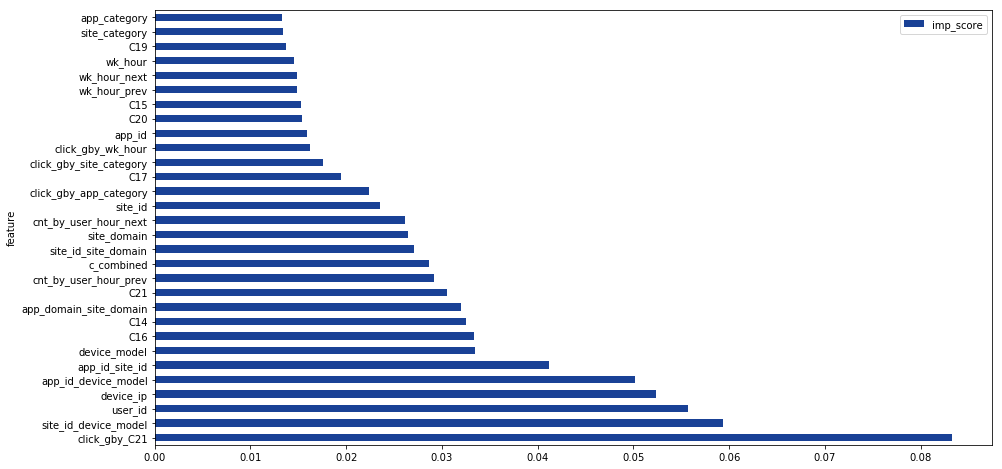

In [30]:
fi.head(30).plot('feature', 'imp_score', 'barh', figsize=(15,8), color='#194196')

A more simpler model with only the top 30 features was also fit but the validation loss did not perform better than the full model.

In [25]:
selected = fi.iloc[:30,0].values

In [26]:
X_filtered_trn = X_train[selected].copy()
X_filtered_val = X_val[selected].copy()

In [27]:
reset_rf_samples()
set_rf_samples(5000000)

In [28]:
%%time
with parallel_backend('threading'):
    rf.fit(X_filtered_trn, y_train)

CPU times: user 8h 27min 57s, sys: 1min 34s, total: 8h 29min 32s
Wall time: 41min 12s


In [29]:
y_pred_proba_trn = rf.predict_proba(X_filtered_trn)
y_pred_proba_val = rf.predict_proba(X_filtered_val)
print("Training Log Loss: ", log_loss(y_train, y_pred_proba_trn))
print("Validation Log Loss: ", log_loss(y_val, y_pred_proba_val))

Training Log Loss:  0.3278944969472111
Validation Log Loss:  0.3991392047212318
